Install library : 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install transformers
!pip install -q sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 30.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.5 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
     |████████████████████████████████| 140 kB 78.7 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 77.1 MB/s 
     |████████████████████████████████| 144 kB 79.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's de

Import library : 

In [3]:
from huggingface_hub import notebook_login

# load dataset library : 
from datasets import load_dataset, load_metric,DatasetDict

# transformers 
import transformers
from transformers import AutoTokenizer,default_data_collator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer


import collections


In [4]:
notebook_login()

!apt install git-lfs


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Loading data set ....

In [54]:
 
dataset = load_dataset('json', data_files={'train': '/content/drive/MyDrive/NLP_CA6/new_jsonfile/PersianQA/pqa_train.json', 
                                            'test': '/content/drive/MyDrive/NLP_CA6/new_jsonfile/PersianQA/pqa_test.json'}, field="data")
dataset

Using custom data configuration default-ef197336c6069b6e


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-ef197336c6069b6e/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 6306
    })
    test: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 651
    })
})

Test / Train / Valiataion split : 

In [55]:

# # Split the 10% test + valid in half test, half valid
test_valid = dataset['train'].train_test_split(test_size=0.05)
# # gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': test_valid['train'],
    'test': dataset['test'],
    'validation': test_valid['test']})
train_test_valid_dataset


DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 5990
    })
    test: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 651
    })
    validation: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 316
    })
})

In [56]:
# just for PasrQuAD dataset : 

# train_test_valid_dataset = dataset

Parameter : 

In [57]:
squad_v2 = False
model_name = "m3hrdadfi/albert-fa-base-v2"
# 
# "m3hrdadfi/albert-fa-base-v2"
# "HooshvareLab/bert-base-parsbert-uncased"
batch_size = 16
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.



Tokenizer : 

In [58]:

tokenizer = AutoTokenizer.from_pretrained(model_name)


pad_on_right = tokenizer.padding_side == "right"

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hid

In [59]:
def data_tokenization(examples):

    examples["question"] = [q.lstrip() for q in examples["question"]]


    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [60]:
tokenized_datasets = train_test_valid_dataset.map(data_tokenization, batched=True, remove_columns=train_test_valid_dataset["train"].column_names)


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 6054
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 651
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 320
    })
})

Model for Question Answering :

In [62]:

model = AutoModelForQuestionAnswering.from_pretrained(model_name)

loading configuration file https://huggingface.co/m3hrdadfi/albert-fa-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5aaead9ced50a1f22c1c73f573769815bde66573e66266a4c7c97c45ef53bc2.ea9ed90d31148db706934d7bf78ea741ea55723122dd930e1c7b974b16e37057
Model config AlbertConfig {
  "_name_or_path": "m3hrdadfi/albert-fa-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "

In [63]:
model_name = model_name.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [64]:

data_collator = default_data_collator

In [65]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/mhmsadegh/albert-fa-base-v2-finetuned-squad into local empty directory.


In [66]:
trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6054
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1137


Epoch,Training Loss,Validation Loss
1,No log,2.539550
2,2.969400,2.405125
3,1.740100,2.486511


***** Running Evaluation *****
  Num examples = 320
  Batch size = 16
Saving model checkpoint to albert-fa-base-v2-finetuned-squad/checkpoint-500
Configuration saved in albert-fa-base-v2-finetuned-squad/checkpoint-500/config.json
Model weights saved in albert-fa-base-v2-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in albert-fa-base-v2-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2-finetuned-squad/checkpoint-500/special_tokens_map.json
tokenizer config file saved in albert-fa-base-v2-finetuned-squad/tokenizer_config.json
Special tokens file saved in albert-fa-base-v2-finetuned-squad/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 320
  Batch size = 16
Saving model checkpoint to albert-fa-base-v2-finetuned-squad/checkpoint-1000
Configuration saved in albert-fa-base-v2-finetuned-squad/checkpoint-1000/config.json
Model weights saved in albert-fa-base-v2-finetuned-squad/checkpoint-10

TrainOutput(global_step=1137, training_loss=2.248364692627597, metrics={'train_runtime': 1434.3481, 'train_samples_per_second': 12.662, 'train_steps_per_second': 0.793, 'total_flos': 300814524417024.0, 'train_loss': 2.248364692627597, 'epoch': 3.0})

Model Evaluation : 

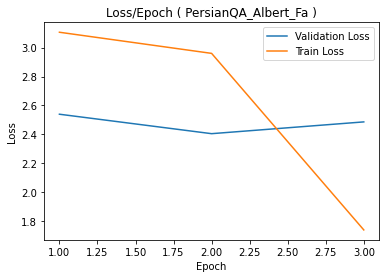

In [87]:
import matplotlib.pyplot as plt
epoch_list = [1,2,3]
train_loss = [3.10600,2.96,1.740100]
val_loss = [2.539550,2.405125,2.486511] 
plt.plot(epoch_list,val_loss,label="Validation Loss")
plt.plot(epoch_list,train_loss,label="Train Loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss/Epoch ( PersianQA_Albert_Fa )")
plt.show()

In [68]:
def prepare_test_features(examples):

    examples["question"] = [q.lstrip() for q in examples["question"]]

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [69]:

test_features = train_test_valid_dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=train_test_valid_dataset["test"].column_names
)

test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [70]:
test_features = train_test_valid_dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=train_test_valid_dataset["test"].column_names
)


test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [71]:
test_features


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 651
})

Test prediction : 

In [72]:
test_pred = trainer.predict(test_features)


The following columns in the test set don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `AlbertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 651
  Batch size = 16


In [73]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    print(features)
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")
    
    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        
        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [74]:
import numpy as np
final_predictions = postprocess_qa_predictions(train_test_valid_dataset["test"], test_features, test_pred.predictions)


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 651
})
Post-processing 651 example predictions split into 651 features.


  0%|          | 0/651 [00:00<?, ?it/s]

In [75]:
metric = load_metric("squad_v2" if squad_v2 else "squad")


if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in train_test_valid_dataset["test"]]


Result on PersianQA test dataset :

In [76]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 37.48079877112135, 'f1': 65.18393791862248}

In [77]:
 
dataset1 = load_dataset('json', data_files='/content/drive/MyDrive/NLP_CA6/new_jsonfile/pquad_public/test_samples.json', field="data")
dataset1

Using custom data configuration default-ad060765033d20f8
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-ad060765033d20f8/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'answers', 'id', 'question'],
        num_rows: 95
    })
})

In [78]:
pquad_test_tokenized = dataset1.map(data_tokenization, batched=True, remove_columns=dataset1["train"].column_names)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [79]:
test_features = dataset1["train"].map(
    prepare_test_features,
    batched=True,
    remove_columns=dataset1["train"].column_names
)

test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))


  0%|          | 0/1 [00:00<?, ?ba/s]

In [80]:
test_pred = trainer.predict(test_features)


The following columns in the test set don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `AlbertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 95
  Batch size = 16


In [81]:
import numpy as np
final_predictions = postprocess_qa_predictions(dataset1["train"], test_features, test_pred.predictions)


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 95
})
Post-processing 95 example predictions split into 95 features.


  0%|          | 0/95 [00:00<?, ?it/s]

In [82]:
metric = load_metric("squad_v2" if squad_v2 else "squad")


if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset1["train"]]

Test on pquad test dataset(Train on PersianQA: dataset): 

In [83]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 48.421052631578945, 'f1': 75.45710964682804}

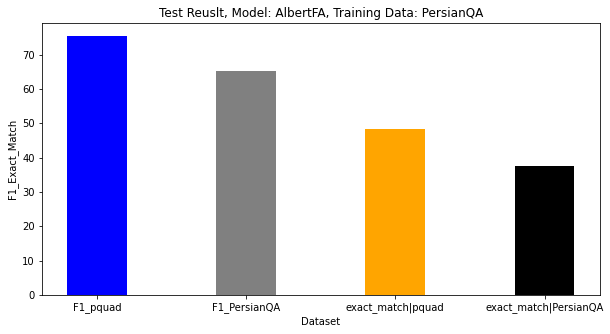

In [86]:
import numpy as np
import matplotlib.pyplot as plt
# creating the dataset
data = {'F1_pquad':75.45, 'F1_PersianQA':65.18, 'exact_match|pquad':48.42,
        'exact_match|PersianQA':37.48}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color =['blue','gray','orange','black'],
        width = 0.4)
 
plt.xlabel("Dataset")
plt.ylabel("F1_Exact_Match")
plt.title("Test Reuslt, Model: AlbertFA, Training Data: PersianQA")
plt.show()